In [1]:
# Import helpful libraries
from copy import deepcopy
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, \
    precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler

from scipy import stats
from yellowbrick.model_selection import LearningCurve, ValidationCurve, cv_scores
from yellowbrick.classifier import ROCAUC


# Utilities for this project
from transformers import ColumnsRemover, StringColumnsRemover, NullThresholdColumnsRemover
from loggers import ResultsLogger
logger = ResultsLogger()

# Hides warnings
import warnings
warnings.filterwarnings('ignore')

# Other helpful settings
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 50)
pd.options.display.float_format = '{:,.2f}'.format

train_data = pd.read_csv('./data/train.csv', index_col=0)
test_data = pd.read_csv('./data/test.csv', index_col=0)

print(train_data.shape, test_data.shape)

(891, 11) (418, 10)


In [2]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,714.00,891.00,891.00,891.00
mean,0.38,2.31,29.70,0.52,0.38,32.20
std,0.49,0.84,14.53,1.10,0.81,49.69
min,0.00,1.00,0.42,0.00,0.00,0.00
25%,0.00,2.00,20.12,0.00,0.00,7.91
50%,0.00,3.00,28.00,0.00,0.00,14.45
75%,1.00,3.00,38.00,1.00,0.00,31.00
max,1.00,3.00,80.00,8.00,6.00,512.33


In [5]:
df = train_data
y_column = 'Survived'

string_cols = list(df.select_dtypes(include=['object']).columns)
string_cols.remove('Name')
string_cols.remove('Cabin')
string_cols.remove('Embarked')
                   
numeric_cols = list(df.select_dtypes(include=['int64', 'float64']).columns)
numeric_cols.remove(y_column)

ignore_cols = ['Name', 'Cabin', 'Embarked']


print(f'{string_cols = }')
print(f'{numeric_cols = }')
print(f'{ignore_cols = }')

string_cols = ['Sex', 'Ticket']
numeric_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
ignore_cols = ['Name', 'Cabin', 'Embarked']


In [6]:
df[y_column].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [7]:
tickets = df['Ticket'].unique()
sorted(tickets)

['110152',
 '110413',
 '110465',
 '110564',
 '110813',
 '111240',
 '111320',
 '111361',
 '111369',
 '111426',
 '111427',
 '111428',
 '112050',
 '112052',
 '112053',
 '112058',
 '112059',
 '112277',
 '112379',
 '113028',
 '113043',
 '113050',
 '113051',
 '113055',
 '113056',
 '113059',
 '113501',
 '113503',
 '113505',
 '113509',
 '113510',
 '113514',
 '113572',
 '113760',
 '113767',
 '113773',
 '113776',
 '113781',
 '113783',
 '113784',
 '113786',
 '113787',
 '113788',
 '113789',
 '113792',
 '113794',
 '113796',
 '113798',
 '113800',
 '113803',
 '113804',
 '113806',
 '113807',
 '11668',
 '11751',
 '11752',
 '11753',
 '11755',
 '11765',
 '11767',
 '11769',
 '11771',
 '11774',
 '11813',
 '11967',
 '12233',
 '12460',
 '12749',
 '13049',
 '13213',
 '13214',
 '13502',
 '13507',
 '13509',
 '13567',
 '13568',
 '14311',
 '14312',
 '14313',
 '14973',
 '1601',
 '16966',
 '16988',
 '17421',
 '17453',
 '17463',
 '17464',
 '17465',
 '17466',
 '17474',
 '17764',
 '19877',
 '19928',
 '19943',
 '19947'

In [8]:
def get_ticket_prefix(ticket):
    if not ' ' in ticket:
        return np.nan
    
    if ticket == 'LINE':
        return ticket
    
    return ''.join(ticket.split()[0:-1])

def get_ticket_number(ticket):
    if ticket.isnumeric():
        return int(ticket)
    
    if ticket == 'LINE':
        return np.nan
    
    return int(ticket.split(' ')[-1])

df['TicketPrefix'] = df['Ticket'].map(get_ticket_prefix)
df['TicketNumber'] = df['Ticket'].map(get_ticket_number)

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketPrefix,TicketNumber
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,A/5,"21,171.00"
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C,PC,"17,599.00"
3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,STON/O2.,"3,101,282.00"
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,NaN,"113,803.00"
5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,NaN,"373,450.00"


In [9]:
df.groupby('Embarked')['TicketPrefix'].value_counts().sort_index()

Embarked  TicketPrefix
C         P/PP             2
          PC              46
          S.C./PARIS       2
          SC               1
          SC/AHBasle       1
                          ..
S         SW/PP            1
          W./C.            9
          W.E.P.           1
          W/C              1
          WE/P             2
Name: TicketPrefix, Length: 44, dtype: int64

In [10]:
df.query('TicketNumber > 260000')['Pclass'].value_counts()

3    308
Name: Pclass, dtype: int64

TicketNumber acima de 260000 são todos da terceira classe

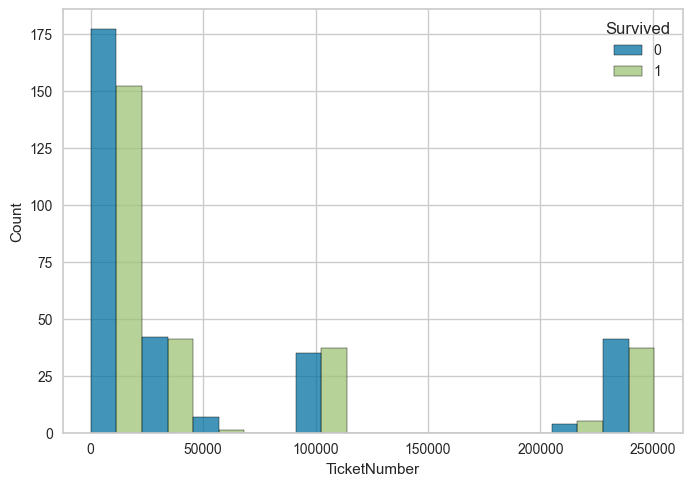

In [12]:
fig, ax = plt.subplots()

ax.ticklabel_format(style='plain')
sns.histplot(
    data=df.query('TicketNumber < 260000'),
    x='TicketNumber',
    hue='Survived',
    multiple='dodge',
    ax=ax,
)
plt.show()